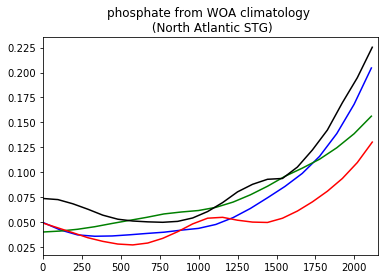

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import netCDF4
import os
import copy
import xarray as xr
from mitgcm.functions import calc_surface, extract_on_surface
from mpl_toolkits import basemap

from STG_nutrient_budget_funcs import *

%matplotlib inline

phosphate_annual = xr.open_dataset('/Users/doddridge/Documents/Edward/Research/datasets/'+
                                   'observations/world_ocean_atlas/phosphate/woa13_all_p00_01.nc'
                                   , decode_times=False)

data_y = (phosphate_annual.variables['lat'][95:115] - phosphate_annual.variables['lat'][95])*60*1.85
data_x =  (phosphate_annual.variables['lon'][90:113] - phosphate_annual.variables['lon'][90])*60*1.85*0.866025403784439


plt.plot(data_y[::-1],phosphate_annual.variables['p_an'][0,0,95:115,130],'b')
plt.plot(data_y,phosphate_annual.variables['p_an'][0,0,113:133,140],'g')
plt.plot(data_x[::-1], phosphate_annual.variables['p_an'][0,0,120,99:122],'r')
plt.plot(data_x, phosphate_annual.variables['p_an'][0,0,120,147:170],'k')
plt.xlim(0,2150)
plt.title('phosphate from WOA climatology \n (North Atlantic STG)');

/Users/doddridge/anaconda2/lib/python2.7/site-packages/mitgcm-0.1-py2.7.egg/mitgcm/functions.py:34: RuntimeWarning: invalid value encountered in less_equal
  if np.all(monoton_test <= 0) or np.all(monoton_test >= 0):
/Users/doddridge/anaconda2/lib/python2.7/site-packages/mitgcm-0.1-py2.7.egg/mitgcm/functions.py:34: RuntimeWarning: invalid value encountered in greater_equal
  if np.all(monoton_test <= 0) or np.all(monoton_test >= 0):
/Users/doddridge/anaconda2/lib/python2.7/site-packages/mitgcm-0.1-py2.7.egg/mitgcm/functions.py:37: RuntimeWarning: input field is not strictly monotonic in search direction. Strange results may occur.
  warnings.warn("input field is not strictly monotonic in search direction. Strange results may occur.", RuntimeWarning)
/Users/doddridge/anaconda2/lib/python2.7/site-packages/mitgcm-0.1-py2.7.egg/mitgcm/functions.py:65: RuntimeWarning: invalid value encountered in greater
  test1 = above > surface_value
/Users/doddridge/anaconda2/lib/python2.7/site-packages/

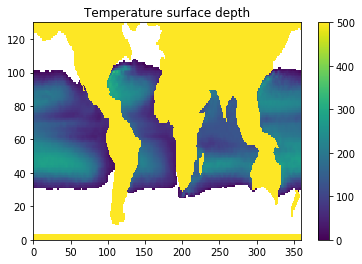

/Users/doddridge/anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


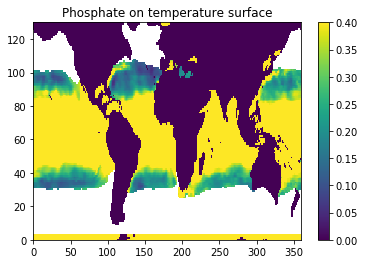

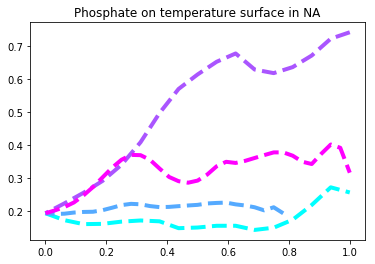

In [2]:
argo_climatology = xr.open_dataset('/Users/doddridge/Documents/Edward/Research/datasets/'+
                                   'observations/Argo/roemmich-gilson_climatology/RG_ArgoClim_Temp.nc',
                                  decode_times=False)

argo_mean_rotated, argo_lon_rotated  = basemap.shiftgrid(181,
                                                         argo_climatology.ARGO_TEMPERATURE_MEAN[:].data,
                                                         argo_climatology.LONGITUDE[:].data)
argo_lon_rotated = argo_lon_rotated - 360

temp_isosurface = calc_surface(argo_mean_rotated,18.5,argo_climatology.PRESSURE.data[:])

plt.figure()
plt.pcolormesh(temp_isosurface,vmin=0,vmax=500)
plt.colorbar()
plt.title('Temperature surface depth')

phosphate_on_isotemp = extract_on_surface(phosphate_annual.p_an.data[0,:,25:155,:],
                                          temp_isosurface,phosphate_annual.depth.data[:])

plt.figure()
plt.pcolormesh(phosphate_on_isotemp,vmin=0,vmax=0.4)
plt.colorbar()
plt.title('Phosphate on temperature surface')

data_y = (phosphate_annual.variables['lat'][95:112] - phosphate_annual.variables['lat'][95])*60*1.85
data_x =  ((phosphate_annual.variables['lon'][130:163] - phosphate_annual.variables['lon'][130])*60*1.85*
           np.cos(phosphate_annual.variables['lat'][113]*np.pi/180.))

plt.figure()
plt.plot(data_y[::-1]/np.max(data_y[::-1]),phosphate_on_isotemp[72:89,130],'--'
         ,linewidth=4,color=plt.cm.cool(0.666))
plt.plot(data_y/np.max(data_y[::-1]),phosphate_on_isotemp[88:105,130],'--'
         ,linewidth=4,color=plt.cm.cool(0.))
plt.plot(data_x[::-1]/np.max(data_x[::-1]), phosphate_on_isotemp[88,98:131],'--'
         ,linewidth=4,color=plt.cm.cool(0.333))
plt.plot(data_x/np.max(data_x[::-1]), phosphate_on_isotemp[88,130:163],'--'
         ,linewidth=4,color=plt.cm.cool(0.999))
plt.title('Phosphate on temperature surface in NA')

# Nutrient budget in cylindrical coordinates

Solve a versin of the diffusion equation to model nutrient distributions in the oligotrophic gyres. Four coupled equations. Two for phosphate, two for dissolved organic phosphate.


For phosphate:
in euphotic zone
$$
h_{\text{euph}}\frac{\partial [PO_{4}]}{\partial t}  = \frac{1}{r}\frac{\partial}{\partial r} \left(\kappa_{h} r h_{\text{euph}}\frac{\partial [PO_{4}]}{\partial r}\right) - \kappa_{z}\left(\frac{[PO_{4}] - [PO_{4 \text{mode}}]}{h_{\text{euph}}}\right) - \frac{1}{2r} \frac{\partial ((w_{\text{Ek}} + \overline{w_{\text{eddy}}}) r^{2} [PO_{4}])}{\partial r} + (w_{\text{Ek}} + \overline{w_{\text{eddy}}})[PO_{4}]- \alpha h_{\text{euph}} I_{c} \frac{[PO_{4}]}{[PO_{4}] + \lambda_{PO_{4}}} + h_{\text{euph}}\gamma_{remin}[DOP] + w_{\text{rms}} A_{\text{eddy}} E_{\text{eddy}} \left([PO_{4 \text{mode}}] - [PO_{4}] \right)
$$

in mode water
$$
h_{mode}\frac{\partial [PO_{4mode}]}{\partial t}  = \frac{1}{r}\frac{\partial}{\partial r} \left(\kappa_{h} r h_{mode} \frac{\partial [PO_{4mode}]}{\partial r}\right) + \kappa_{z} \frac{[PO_{4}] - [PO_{4mode}]}{h_{euph}} - \kappa_{z} \frac{[PO_{4mode}] - [PO_{4abyss}]}{h_{mode}}  + \frac{1}{2r} \frac{\partial ((w_{Ek} + \overline{w_{eddy}}) r^{2} [PO_{4mode}])}{\partial r} - (w_{Ek} + \overline{w_{eddy}}) [PO_{4}] + (1-f_{DOP})\alpha h_{euph}I_{c} \frac{[PO_{4}]}{[PO_{4}] + \lambda_{PO_{4}}}\left(1 - \left(\frac{h_{mode}+ h_{euph}}{h_{euph}}\right)^{-0.988}\right)  + h_{mode}\gamma_{remin}[DOP_{mode}]  - w_{rms} A_{eddy} E_{eddy} \left([PO_{4mode}] - [PO_{4}]\right)
$$

For DOP:
in euphotic zone
$$
h_{euph}\frac{\partial [DOP]}{\partial t}  = \frac{1}{r}\frac{\partial}{\partial r} \left(\kappa_{h} r h_{euph} \frac{\partial [DOP]}{\partial r}\right) - \kappa_{z}\left(\frac{[DOP] - [DOP_{mode}]}{h_{euph}}\right) - \frac{1}{2r} \frac{\partial ((w_{Ek} + \overline{w_{eddy}}) r^{2} [DOP])}{\partial r} + (w_{Ek} + \overline{w_{eddy}})[DOP] + f_{DOP}\alpha h_{euph} I_{c} \frac{[PO_{4}]}{[PO_{4}] - \lambda_{PO_{4}}} - h_{euph} \gamma_{remin} [DOP] + w_{rms} A_{eddy} E_{eddy} \left([DOP_{mode}] - [DOP]\right)
$$

in mode water
$$
h_{mode}\frac{\partial [DOP_{mode}]}{\partial t}  =  \frac{1}{r}\frac{\partial}{\partial r} \left(\kappa_{h} r h_{mode}\frac{\partial [DOP_{mode}]}{\partial r}\right) + \kappa_{z}\left(\frac{[DOP] - [DOP_{mode}]}{h_{euph}}\right) + \frac{1}{2r} \frac{\partial ((w_{Ek} + \overline{w_{eddy}}) r^{2} [DOP_{mode}])}{\partial r} - (w_{Ek} + \overline{w_{eddy}})[DOP] - h_{mode} \gamma_{remin} [DOP_{mode}] - w_{rms} A_{eddy} E_{eddy} \left([DOP_{mode}] - [DOP]\right)
$$


Solve with Dirichlet conditions for PO4 at the gyre edge (set value), and with Neumann conditions at the centre (set derivative to be zero, so there's no flux).

# Sensitivity testing
## Parameters
Many are from 
* Dutkiewicz, S., Sokolov, A. P., Scott, J., & Stone, P. H. (2005). A Three-Dimensional Ocean-Seaice-Carbon Cycle Model and its Coupling to a Two-Dimensional Atmospheric Model: Uses in Climate Change Studies.

In [3]:
params = default_params()
numerics = default_numerics()

r = numerics['r'] # for plotting - it's just easier

Use a linear multistep method, third order Adams-Bashforth, to integrate to steady-state.

## Sensitivity tests

Give a range of values for parameters and look at the results.

In [4]:
perturb_param = 'kappa_h'
values = np.array([10.,100.,500.,1000.,1500.,2000.,2500.,3000.])

perturb_param = 'kappa_z'
values = np.array([0,1e-5,5e-5,1e-4,5e-4])

perturb_param = 'w_ek'
values = np.array([0.,-20.,-40.,-60.,-80.])

perturb_param = 'w_rms'
values = np.array([0.0, 0.4,0.8,1.2,1.6,2.0])

perturb_param = 'A_eddy'
values = np.array([0.,0.05,0.1,0.15,0.2,0.25,0.3,0.35])

perturb_param = 'alpha'
values = np.array([0.,2e-4,4e-4,8.199360000000001e-4,1.6e-3,3e-3,6e-3])

perturb_param = 'lambda_po4'
values = np.array([1e-6,1e-5,1e-4,5e-4,1e-3,5e-3,1e-2])

perturb_param = 'gamma_remin'
values = np.array([0.5,1.,2.,3.,4.])

perturb_param = 'f_DOP'
values = np.array([0.47,0.57,0.67,0.77,0.87])

perturb_param = 'gyre_edge_conc'
values = np.array([1e-4,1.4e-4,1.8e-4,2.2e-4,2.6e-4])

perturb_param = 'gyre_edge_DOP'
values = np.array([4e-5,6e-5,8e-5,10e-5,12e-5,14e-5,16e-5,18e-5,20e-5])

perturb_param = 'h_euph'
values = np.array([40.,60.,80.,100.,120.])


perturb_param = 'h_mode'
values = np.array([50., 150., 250., 350., 450., 550.])

perturb_param = 'default'
values = np.array([0.])


params['EL_base_grad'] = 1e-6            # mol/m^3/m - vertical gradient in phosphate at base of euphotic zone
params['EL_base_conc'] = 1.8e-10         # mol/m^3 - concentration of phosphate at base of euphotic zone

In [5]:
data_y = (phosphate_annual.variables['lat'][95:112] - phosphate_annual.variables['lat'][95])*60*1.85
data_x =  ((phosphate_annual.variables['lon'][130:163] - phosphate_annual.variables['lon'][130])*60*1.85*
           np.cos(phosphate_annual.variables['lat'][113]*np.pi/180.))

In [ ]:
perturb_param = 'default'
values = np.array([0.])

folder = 'parameter_testing/' + perturb_param + ''

try:
    os.mkdir(folder)
except:
    print 'failed to make ' + folder + ' seems to exist already'

with open(folder + '/changed_values.txt', 'w') as f:
    f.write(str(values))
f.closed

with open(folder + '/default_params.txt', 'w') as f:
    f.write(str(params))
f.closed

PO4 = np.ones((len(values),len(numerics['r'])))*params['gyre_edge_conc']
PO4M = np.ones((len(values),len(numerics['r'])))*params['gyre_edge_conc']
DOP = np.zeros((len(values),len(numerics['r'])))
DOPM = np.zeros((len(values),len(numerics['r'])))

dPO4dt = np.zeros((len(values),3,len(numerics['r'])))
dPO4Mdt = np.zeros((len(values),3,len(numerics['r'])))
dDOPdt = np.zeros((len(values),3,len(numerics['r'])))
dDOPMdt = np.zeros((len(values),3,len(numerics['r'])))



for n in xrange(len(values)):
    params_copy = copy.deepcopy(params)
    params_copy[perturb_param] = values[n]

    (PO4[n,:],PO4M[n,:],DOP[n,:],DOPM[n,:],
     dPO4dt[n,:,:],dPO4Mdt[n,:,:],dDOPdt[n,:,:],dDOPMdt[n,:,:]) = run_model_2L(PO4[n,:]
                                                                               ,PO4M[n,:]
                                                                               ,DOP[n,:]
                                                                               ,DOPM[n,:]
                                                                               ,params_copy,numerics)

    plt.figure(figsize=(12,12))
    for n in xrange(len(values)):
        plt.plot(r/np.max(r),PO4[n,:]*1e3,color=plt.cm.viridis(float(n)/len(values)),linewidth=3,
                 label=perturb_param + ' = ' + str(values[n]))
    z1 = 0
    z2 = 20
    # 0,20 = top 100 m
    # 21,29 for 200 m below that
    
    # use phosphate concentration extracted on isotemp surface of 18C
    
    plt.plot(data_y[::-1]/np.max(data_y[::-1]),
             np.nanmean(phosphate_annual.variables['p_an'][0,z1:z2,97:114,130],axis=0),'--'
             ,linewidth=4,color=plt.cm.cool(0.666))
    plt.plot(data_y/np.max(data_y[::-1]),
             np.nanmean(phosphate_annual.variables['p_an'][0,z1:z2,113:130,130],axis=0),'--'
             ,linewidth=4,color=plt.cm.cool(0.))
    plt.plot(data_x[::-1]/np.max(data_x[::-1]),
             np.nanmean(phosphate_annual.variables['p_an'][0,z1:z2,113,98:131],axis=0),'--'
             ,linewidth=4,color=plt.cm.cool(0.333))
    plt.plot(data_x/np.max(data_x[::-1]),
             np.nanmean(phosphate_annual.variables['p_an'][0,z1:z2,113,130:163],axis=0),'--'
             ,linewidth=4,color=plt.cm.cool(0.999))

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Normalised distance from gyre centre',fontsize=20)
    plt.ylabel('Phosphate concentration ($\mu$mol L$^{-1}$)',fontsize=20)
    plt.title('Phosphate concentration in upper ocean ($\mu$mol/L)')
    plt.legend(loc=0)

    plt.savefig(folder + '/' + perturb_param + 'PO4.pdf', bbox_inches='tight')
    plt.close()

    
    plt.figure(figsize=(12,12))
    for n in xrange(len(values)):
        plt.plot(r/np.max(r),PO4M[n,:]*1e3,color=plt.cm.viridis(float(n)/len(values)),linewidth=3,
                 label=perturb_param + ' = ' + str(values[n]))

    plt.plot(data_y[::-1]/np.max(data_y[::-1]),phosphate_on_isotemp[72:89,130],'--'
             ,linewidth=4,color=plt.cm.cool(0.666))
    plt.plot(data_y/np.max(data_y[::-1]),phosphate_on_isotemp[88:105,130],'--'
             ,linewidth=4,color=plt.cm.cool(0.))
    plt.plot(data_x[::-1]/np.max(data_x[::-1]), phosphate_on_isotemp[88,98:131],'--'
             ,linewidth=4,color=plt.cm.cool(0.333))
    plt.plot(data_x/np.max(data_x[::-1]), phosphate_on_isotemp[88,130:163],'--'
             ,linewidth=4,color=plt.cm.cool(0.999))

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Normalised distance from gyre centre',fontsize=20)
    plt.ylabel('Phosphate concentration ($\mu$mol L$^{-1}$)',fontsize=20)
    plt.title('Phosphate concentration in mode water ($\mu$mol/L)')
    plt.legend(loc=0)


    plt.savefig(folder + '/' + perturb_param + 'PO4 mode water.pdf', bbox_inches='tight')
    plt.close()
    
    plt.figure(figsize=(12,12))
    for n in xrange(len(values)):
        plt.plot(r/np.max(r),DOP[n,:]*1e3,color=plt.cm.viridis(float(n)/len(values)),linewidth=3,
                 label=perturb_param + ' = ' + str(values[n]))
    plt.title('DOP concentration in upper ocean ($\mu$mol/L)')
    plt.xlabel('Distance from gyre centre (km)',fontsize=20);
    plt.legend(loc=0)
    plt.savefig(folder + '/' + perturb_param + 'DOP.pdf', bbox_inches='tight')
    plt.close()

    
    plt.figure(figsize=(12,12))
    for n in xrange(len(values)):
        plt.plot(r/np.max(r),DOPM[n,:]*1e3,color=plt.cm.viridis(float(n)/len(values)),linewidth=3,
                 label=perturb_param + ' = ' + str(values[n]))
    plt.title('DOP concentration in mode water ($\mu$mol/L)')
    plt.xlabel('Distance from gyre centre (km)',fontsize=20);
    plt.legend(loc=0)
    plt.savefig(folder + '/' + perturb_param + 'DOP mode water.pdf', bbox_inches='tight')
    plt.close()
    
np.save(folder + '/PO4.npy',PO4)
np.save(folder + '/PO4M.npy',PO4M)
np.save(folder + '/DOP.npy',DOP)
np.save(folder + '/DOPM.npy',DOPM)
np.save(folder + '/dPO4dt.npy',dPO4dt)
np.save(folder + '/dPO4Mdt.npy',dPO4Mdt)
np.save(folder + '/dDOPdt.npy',dDOPdt)
np.save(folder + '/dDOPMdt.npy',dDOPMdt)
